## Learning with Ensembles

In [1]:
# Show how with 25% error rate in each classifier, it is higher when doing majority vote with ensemble
from scipy.special import comb
import math

# Function to compute the probability that an ensemble of classifiers 
# makes a wrong prediction given individual classifier error rates.
def ensemble_error(n_classifier, error):
    # Majority vote threshold: at least half (rounded up) must be wrong
    k_start = int(math.ceil(n_classifier / 2.))
    
    # Compute probability of k classifiers being wrong out of n_classifier
    probs = [
        comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k)
        for k in range(k_start, n_classifier + 1)
    ]
    
    # Total probability of the ensemble being wrong
    return sum(probs)

# Example: 11 classifiers, each with error rate = 0.25
print(ensemble_error(n_classifier=11, error=0.25))

0.03432750701904297


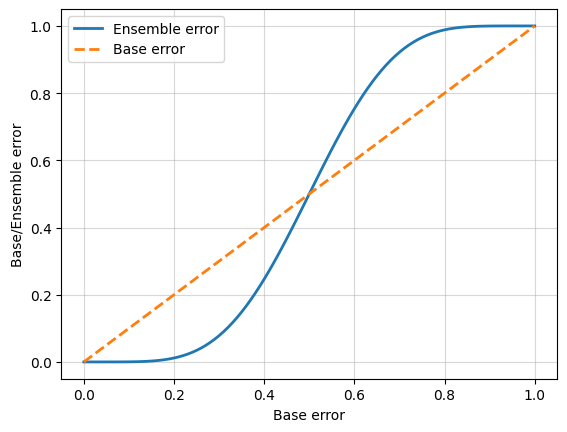

In [2]:
# Visualize the ensemble error for different error rates
import numpy as np
import matplotlib.pyplot as plt

# Define a range of possible base error rates from 0 to 1
error_range = np.arange(0.0, 1.01, 0.01)

# Compute ensemble error for 11 classifiers across the base error range
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

# Plot ensemble error vs. base error
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)

# Plot baseline (ensemble error = base error, i.e., single classifier)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)

# Labels, legend, and grid
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show() # as long as base classifiers perform better than random, ensemble will perform better

## Combining classifiers via majority voting

In [3]:
# Example of weighted voting using numpy
import numpy as np

# Weighted voting example:
# - class 0 gets two votes with weights 0.2 and 0.2 → total = 0.4
# - class 1 gets one vote with weight 0.6 → total = 0.6
# np.bincount sums votes per class, weighted
# np.argmax finds the class with the highest total weight

result = np.argmax(np.bincount([0, 0, 1],
                               weights=[0.2, 0.2, 0.6]))
print(result) 

1


In [4]:
# Example of soft voting strategy for ensembles instead of majority voting
# Soft voting uses predicted probabilities instead of hard class labels
import numpy as np

# Example: probability outputs from 3 classifiers for 2 classes
ex = np.array([[0.9, 0.1],   # classifier 1: 90% class 0, 10% class 1
               [0.8, 0.2],   # classifier 2: 80% class 0, 20% class 1
               [0.4, 0.6]])  # classifier 3: 40% class 0, 60% class 1

# Weighted averaging of probabilities
# Weights: [0.2, 0.2, 0.6] → classifier 3 is most trusted
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)  # [0.58 0.42]

# Final prediction = class with max average probability
print(np.argmax(p))

[0.58 0.42]
0


### Using majority voting principle to make predictions

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the full Iris dataset (150 samples, 3 classes: Setosa, Versicolor, Virginica)
iris = datasets.load_iris()

# Select only samples from index 50 onward (i.e., Versicolor and Virginica only)
# -> This makes it a binary classification problem (2 classes instead of 3).
X, y = iris.data[50:, [1, 2]], iris.target[50:]

# Encode labels into 0 and 1 (needed because target originally contains 1 and 2)
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.5,     # 50% train, 50% test
                     random_state=1,    # ensures reproducibility
                     stratify=y)        # preserve class balance

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define classifiers with their parameters
clf1 = LogisticRegression(penalty='l2',   # L2 regularization
                          C=0.001,         # Inverse of regularization strength
                          solver='lbfgs',  # Optimization algorithm
                          random_state=1)  # Seed for reproducibility

clf2 = DecisionTreeClassifier(max_depth=1,       # Tree depth limit
                              criterion='entropy', # Use information gain
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,        # Number of neighbors to use
                            p=2,                  # Use Euclidean distance (p=2)
                            metric='minkowski')

# Create pipelines for classifiers that need feature scaling
pipe1 = Pipeline([['sc', StandardScaler()],      # Scale features before logistic regression
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],      # Scale features before KNN
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

# Evaluate each classifier using 10-fold cross-validation with ROC AUC metric
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,            # 10-fold cross-validation
                             scoring='roc_auc') # Use ROC AUC as scoring metric
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [8]:
from MajorityVotingClassifier import MajorityVoteClassifier
# Create MajorityVoteClassifier ensemble with the 3 classifiers
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
)

# Add the ensemble to the list of classifier labels
clf_labels += ['Majority voting']

# List of all classifiers including the ensemble
all_clf = [pipe1, clf2, pipe3, mv_clf]

# Evaluate each classifier using 10-fold cross-validation with ROC AUC scoring
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,            # 10-fold cross-validation
                             scoring='roc_auc') # ROC AUC metric
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: nan (+/- nan) [Majority voting]


C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: MajorityVoteClassifier 

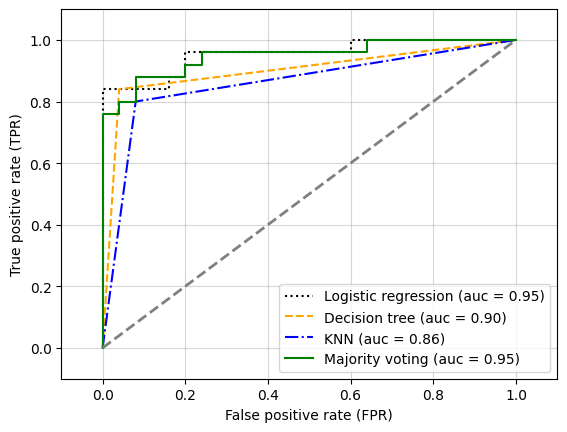

In [9]:
# Make a ROC AUC plot to compare classifiers
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue', 'green']    # Colors for each classifier's ROC curve
linestyles = [':', '--', '-.', '-']              # Line styles for each ROC curve

# Loop over classifiers and plot ROC curves
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # Fit the classifier and get predicted probabilities for positive class (assumed label=1)
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    # Compute false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    
    # Compute area under the ROC curve
    roc_auc = auc(x=fpr, y=tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

# Add legend to lower right
plt.legend(loc='lower right')

# Plot diagonal line for random guessing baseline
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

# Set axis limits with some padding
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])

# Show grid with transparency
plt.grid(alpha=0.5)

# Label axes
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

# Display the plot
plt.show()


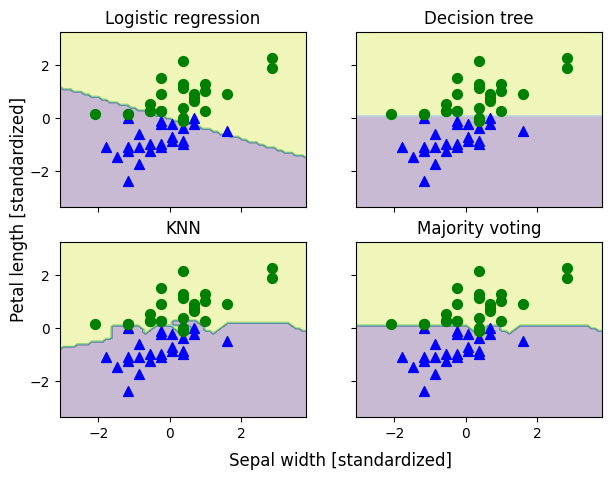

In [10]:
# Standardize the dataset (although not necessary as logistic regression and k-nearest neighbors already do it), then visualize the decision boundaries of the classifiers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import product

# Standardize features (mean=0, std=1)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

# Define min and max values for the grid to plot decision regions
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

# Create a meshgrid covering the feature space with 0.1 step size
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Create a 2x2 grid of subplots with shared x-axis for columns and y-axis for rows
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

# Loop over subplot indices (row, col), classifiers, and their labels simultaneously
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    # Fit classifier on standardized training data
    clf.fit(X_train_std, y_train)

    # Predict class labels for each point in the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  # flatten grid points and combine as 2D features

    # Reshape predictions back into grid shape for contour plotting
    Z = Z.reshape(xx.shape)

    # Plot decision regions as filled contours with transparency alpha=0.3
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    # Plot training samples of class 0 with blue triangle markers
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    # Plot training samples of class 1 with green circle markers
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    # Set subplot title to classifier name
    axarr[idx[0], idx[1]].set_title(tt)

# Add common x-axis label centered below the plots
plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)

# Add common y-axis label centered left of the plots, rotated vertically
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

plt.show()


In [11]:
# get all parameters of your MajorityVoteClassifier instance, including parameters of its underlying classifiers
mv_clf.get_params()
# Now we know how to access the inidividual classifer's attributes, so we can now tune the inverse regularization parameter C of the logistic regression classifier in the ensemble

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [12]:
# Tune using a grid search
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning:
# - For the DecisionTreeClassifier inside MajorityVoteClassifier, tune max_depth (1 or 2)
# - For the LogisticRegression inside the pipeline named 'pipeline-1', tune regularization C parameter
params = {
    'decisiontreeclassifier__max_depth': [1, 2],
    'pipeline-1__clf__C': [0.001, 0.1, 100.0]
}

# Set up GridSearchCV with the ensemble classifier (mv_clf)
# cv=10 means 10-fold cross-validation
# scoring='roc_auc' uses ROC AUC metric to evaluate performance
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')

# Fit grid search on training data to find the best hyperparameters
grid.fit(X_train, y_train)

C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\

,estimator,MajorityVoteC...ghbors=1)]])])
,param_grid,"{'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,pipeline-1,Pipeline(step...om_state=1)]])


In [13]:
# Print the different hyperparameter combos and average ROC AUC scores
# Loop through all results from GridSearchCV
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    # Get the mean test score for this parameter setting
    mean_score = grid.cv_results_['mean_test_score'][r]
    # Get the standard deviation of test score (spread across CV folds)
    std_dev = grid.cv_results_['std_test_score'][r]
    # Get the parameter setting for this result
    params = grid.cv_results_['params'][r]
    # Print mean score ± std dev and parameters used
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [ ]:
# Print the best parameter combination found by GridSearchCV
print(f'Best parameters: {grid.best_params_}')

# Print the best ROC AUC score achieved with those parameters
print(f'ROC AUC : {grid.best_score_:.2f}')